### Library

In [82]:
import re
import glob
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer, mean_absolute_percentage_error, mean_squared_error
from scipy import stats
from scipy.stats import zscore, uniform, randint

### Dataset

In [83]:
df = pd.read_csv('../data/data.csv')

### Data Preparation

In [84]:
# Mengubah nama kolom
df = df.rename(columns={
    'Model Pakaian': 'model',
    'Jenis Bahan': 'bahan',
    'Waktu Pengerjaan (hari)': 'waktu_pengerjaan',
    'Detail Tambahan': 'ornamen',
    'Harga Jasa (Rp)': 'harga_jasa'
})

In [85]:
# Merubah data pada kolom 'harga_jasa' menjadi numerik
def clean_price(price):
    return int(str(price).replace('Rp', '').replace('.', '').replace(',', '').strip()) if pd.notna(price) else None

df['harga_jasa'] = df['harga_jasa'].apply(clean_price)
df = df.dropna(subset=['harga_jasa'])

In [86]:
# Cek data unik pada tiap variabel kategori
for col in ['model', 'bahan', 'ornamen']:
    print(f"{col.title()}:\n", df[col].unique(), "\n")

Model:
 ['Blus' 'Gaun maxi' 'Gaun midi' 'Kebaya modern' 'Kebaya Tradisional'
 'Kebaya Modern' 'Maxi Dress' 'Midi Dress'] 

Bahan:
 ['Katun' 'Satin' 'Sifon' 'Sutra' 'Brokat'] 

Ornamen:
 ['bordir tempel' 'renda' '-' 'opneisel terbuka' 'payet aksen kecil'
 'payet aksen sedang' 'payet aksen besar' 'bordir besar'
 'opneisel tertutup' 'payet  aksen kecil' 'payet motif besar'
 'payet  motif sedang' 'renda ' 'payet motif sedang' 'bordir sedang'
 'bordir kecil' 'payet motif  sedang' 'payet  aksen besar' ' bordir kecil'
 'bordir  sedang' 'bordir sedang ' 'bordir kecil ' 'bordir tempel '
 'payet aksen  sedang' ' bordir sedang' ' bordir besar' 'bordir  besar'
 'bordir  kecil' 'bordir besar ' 'bordir  besar ' 'bordir  sedang '
 'opneisel  tertutup'] 



In [87]:
# Standarisasi format variabel kategori
cat_cols = ['model', 'bahan', 'ornamen']

for col in cat_cols:
    df[col] = df[col].str.title().str.strip().str.replace(r'\s+', ' ', regex=True)

In [88]:
# Menyeragamkan penulisan data di kolom 'model' dan 'ornamen'
df.replace({
    'model': {
        'Gaun Midi': 'Midi Dress', 
        'Gaun Maxi': 'Maxi Dress'},
    'ornamen': {
        '-': 'None'
    }
}, inplace=True)

### Exploratory Data Analysis

In [89]:
df.head()

,model,bahan,ornamen,waktu_pengerjaan,harga_jasa
0,Blus,Katun,Bordir Tempel,4,250000
1,Blus,Katun,Renda,7,175000
2,Blus,Satin,None,7,150000
3,Blus,Satin,Opneisel Terbuka,10,175000
4,Blus,Sifon,Opneisel Terbuka,6,175000


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1114 entries, 0 to 1113
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   model             1114 non-null   object
 1   bahan             1114 non-null   object
 2   ornamen           1114 non-null   object
 3   waktu_pengerjaan  1114 non-null   int64 
 4   harga_jasa        1114 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 43.6+ KB


In [91]:
df.duplicated().sum()

np.int64(143)

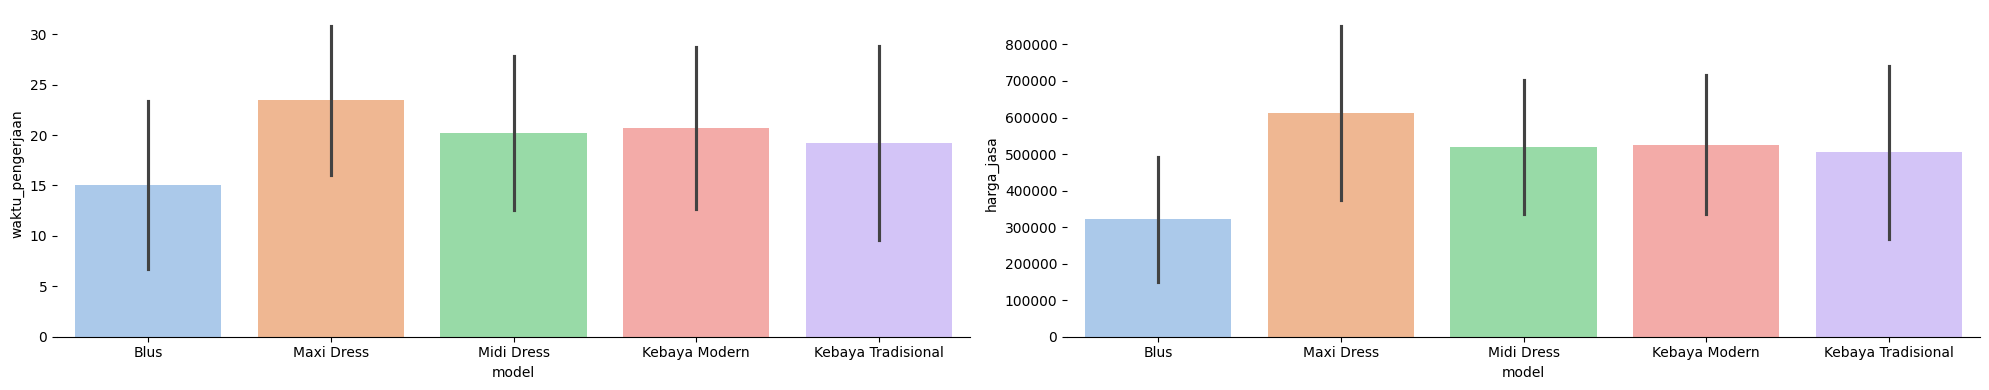

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
sns.despine(left=True)
sns.barplot(data=df, x='model', y='waktu_pengerjaan', hue='model', errorbar='sd', palette='pastel', ax=axes[0])
sns.barplot(data=df, x='model', y='harga_jasa', hue='model', errorbar='sd', palette='pastel', ax=axes[1])
plt.tight_layout()
plt.show()

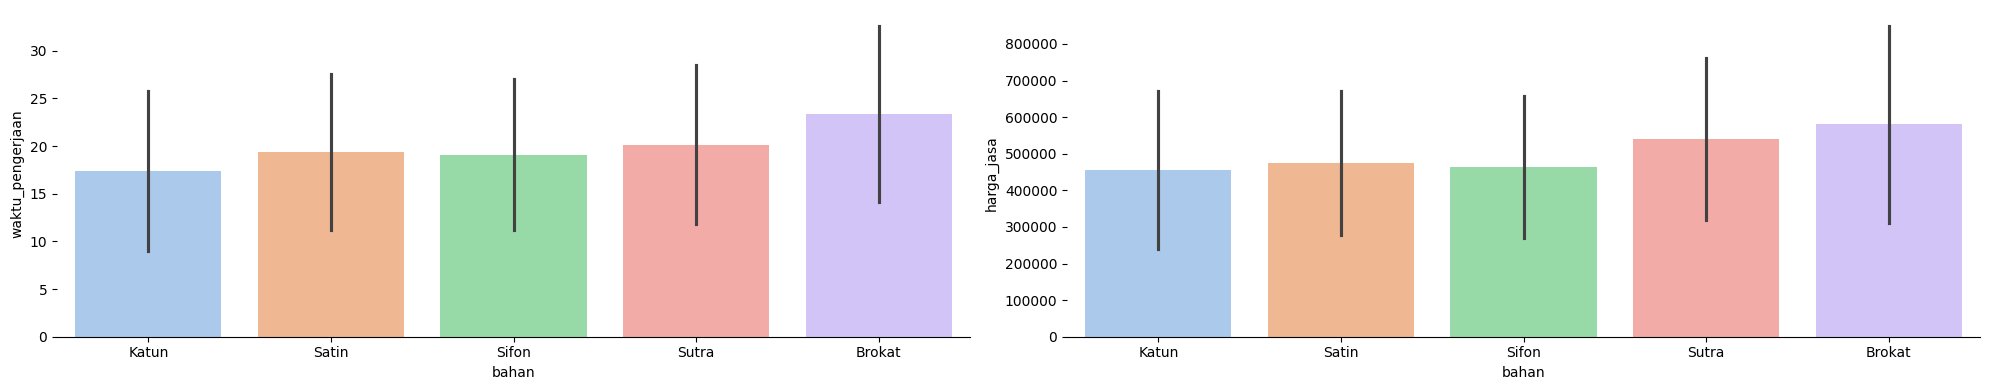

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
sns.despine(left=True)
sns.barplot(data=df, x='bahan', y='waktu_pengerjaan', hue='bahan', errorbar='sd', palette='pastel', ax=axes[0])
sns.barplot(data=df, x='bahan', y='harga_jasa', hue='bahan', errorbar='sd', palette='pastel', ax=axes[1])
plt.tight_layout()
plt.show()

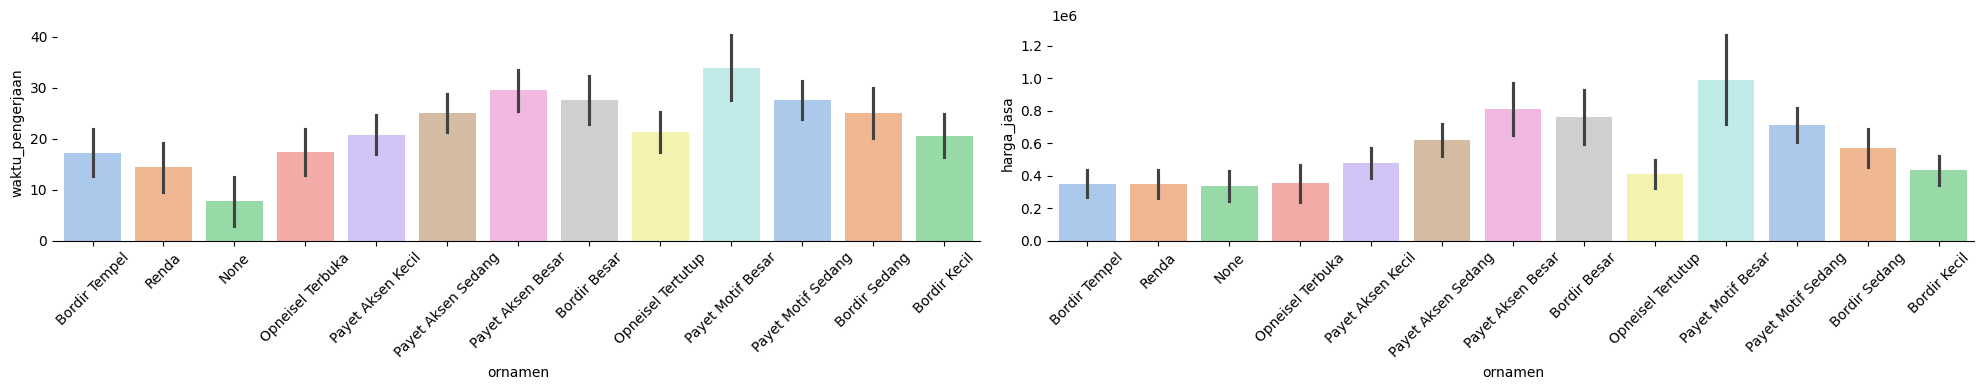

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
sns.despine(left=True)
sns.barplot(data=df, x='ornamen', y='waktu_pengerjaan', hue='ornamen', errorbar='sd', palette='pastel', ax=axes[0])
sns.barplot(data=df, x='ornamen', y='harga_jasa', hue='ornamen', errorbar='sd', palette='pastel', ax=axes[1])
axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

<Axes: xlabel='harga_jasa', ylabel='Count'>

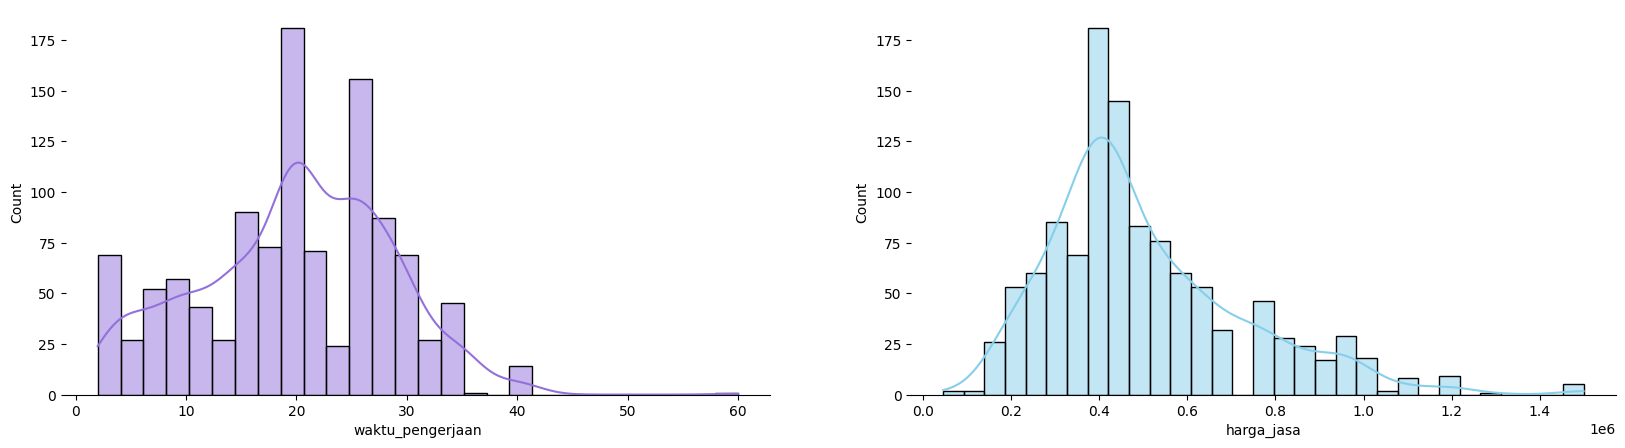

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.despine(left=True)
sns.histplot(df.waktu_pengerjaan, color="mediumpurple", kde=True, ax=axes[0])
sns.histplot(df.harga_jasa, color="skyblue", kde=True, ax=axes[1])

### Preprocessing

In [96]:
# Menghapus duplikasi data
before = len(df)
df = df.drop_duplicates()
after = len(df)

if before > after:
    print(f"{before - after} data duplikat berhasil dihapus")
else:
    print("Tidak ada data duplikat yang ditemukan")

143 data duplikat berhasil dihapus


In [97]:
# Menangani outlier dengan Z-score
df = df[
    (np.abs(zscore(df['waktu_pengerjaan'])) < 2) &
    (np.abs(zscore(df['harga_jasa'])) < 3)
]

### Transformasi

In [98]:
# Pemisahan fitur dan target
X = df[['model', 'bahan', 'ornamen']]
y = df[['waktu_pengerjaan', 'harga_jasa']]

In [99]:
# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [100]:
train_set = pd.concat([X_train, y_train], axis=1)
test_set = pd.concat([X_test, y_test], axis=1)

print("Jumlah data latih:", len(train_set))
print("Jumlah data uji:", len(test_set))

Jumlah data latih: 744
Jumlah data uji: 187


In [101]:
# Menampilkan contoh data latih
pd.concat([train_set.head(3), train_set.tail(3)])

,model,bahan,ornamen,waktu_pengerjaan,harga_jasa
55,Kebaya Tradisional,Sifon,Bordir Besar,30,950000
326,Kebaya Modern,Brokat,Bordir Kecil,20,450000
576,Blus,Satin,Bordir Besar,28,750000
998,Blus,Katun,Opneisel Terbuka,22,225000
495,Kebaya Tradisional,Satin,Payet Aksen Besar,32,750000
106,Kebaya Modern,Sutra,Renda,18,450000


In [102]:
# Menampilkan contoh data uji
print("Contoh data uji:")
pd.concat([test_set.head(3), test_set.tail(3)])

Contoh data uji:


,model,bahan,ornamen,waktu_pengerjaan,harga_jasa
956,Maxi Dress,Sifon,Bordir Kecil,20,600000
72,Blus,Sutra,Renda,10,250000
726,Blus,Katun,Renda,15,300000
845,Midi Dress,Katun,Bordir Kecil,25,450000
630,Kebaya Tradisional,Satin,Payet Aksen Kecil,28,400000
5,Blus,Sifon,None,10,150000


In [103]:
# One-hot encoding
trans = ColumnTransformer(
    transformers=[
        ('coder', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)

In [104]:
# Terapkan transformasi pada data latih
X_train_encoded = trans.fit_transform(X_train)

encoded_df = pd.DataFrame(X_train_encoded, columns=trans.get_feature_names_out())
encoded_df.head()

,coder__model_Kebaya Modern,coder__model_Kebaya Tradisional,coder__model_Maxi Dress,coder__model_Midi Dress,coder__bahan_Katun,coder__bahan_Satin,coder__bahan_Sifon,coder__bahan_Sutra,coder__ornamen_Bordir Kecil,coder__ornamen_Bordir Sedang,coder__ornamen_Bordir Tempel,coder__ornamen_None,coder__ornamen_Opneisel Terbuka,coder__ornamen_Opneisel Tertutup,coder__ornamen_Payet Aksen Besar,coder__ornamen_Payet Aksen Kecil,coder__ornamen_Payet Aksen Sedang,coder__ornamen_Payet Motif Besar,coder__ornamen_Payet Motif Sedang,coder__ornamen_Renda
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Pemodelan Linear Regression

In [105]:
# Linear Regression
lr = MultiOutputRegressor(LinearRegression(fit_intercept=True))

pipe_lr = Pipeline([
    ('transform', trans),
    ('model', lr)
])

pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('coder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['model', 'bahan',
                                                   'ornamen'])])),
                ('model', MultiOutputRegressor(estimator=LinearRegression()))])

In [106]:
# Output model
for i, est in enumerate(pipe_lr.named_steps['model'].estimators_):
    print(f"Target {i+1}: Intercept = {est.intercept_}, Coefficients = {est.coef_}")

Target 1: Intercept = 26.474258199500998, Coefficients = [  3.22005027   1.34551017   5.28707752   3.65196508  -2.24046438
  -0.59107503  -0.97065841   0.10007338  -7.6931019   -3.24258398
 -11.53362522 -19.52526899 -11.51188811  -7.50927866   0.33236175
  -8.31801264  -4.00562517   2.63679346  -1.9864234  -13.55742463]
Target 2: Intercept = 653652.6677779623, Coefficients = [ 157242.28567958  103138.14009528  223654.47149435  175366.27467466
  -11475.78822987   -5905.53266369    -663.58992529   62451.08530069
 -358757.98503965 -224827.04933467 -449615.44255668 -451547.20355883
 -444857.61509622 -414548.47409391   -6289.23805522 -338295.87787246
 -198849.13907279   56911.24651059 -119797.06264485 -441789.59658891]


### Evaluasi

In [107]:
# Linear Regression
y_pred_lr = pipe_lr.predict(X_test)

r2_lr = r2_score(y_test, y_pred_lr, multioutput='raw_values')
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr, multioutput='raw_values'))

print("Linear Regression")
print(f"R² Waktu Pengerjaan: {r2_lr[0]:.4f} | RMSE: {rmse_lr[0]:,.4f}")
print(f"R² Harga Jasa:       {r2_lr[1]:.4f} | RMSE: {rmse_lr[1]:,.2f}")

Linear Regression
R² Waktu Pengerjaan: 0.7917 | RMSE: 3.6937
R² Harga Jasa:       0.9208 | RMSE: 58,194.23


In [108]:
r2_avg   = r2_score(y_test, y_pred_lr, multioutput='uniform_average')
rmse_avg = np.sqrt(mean_squared_error( y_test, y_pred_lr))

print(f"R² (avg):  {r2_avg:.4f}  |  RMSE (avg): {rmse_avg:.4f}")

R² (avg):  0.8563  |  RMSE (avg): 41149.5318


In [109]:
# Pilih 5 baris acak dan buat prediksi
idx = X_test.sample(5, random_state=42).index
preds = pipe_lr.predict(X_test.loc[idx])

# Gabungkan hasil aktual dan prediksi
comparison = X_test.loc[idx].copy()
comparison['Aktual Waktu'] = y_test.loc[idx, 'waktu_pengerjaan']
comparison['Aktual Harga'] = y_test.loc[idx, 'harga_jasa']
comparison['Prediksi Waktu'] = preds[:, 0]
comparison['Prediksi Harga'] = preds[:, 1]

# Tampilkan hasil dengan format tanpa desimal
print(comparison.to_string(index=False, float_format='{:,.0f}'.format))

             model  bahan           ornamen  Aktual Waktu  Aktual Harga  Prediksi Waktu  Prediksi Harga
Kebaya Tradisional  Satin Payet Aksen Kecil            28        400000              19         412,589
              Blus  Sifon              None             8        150000               6         201,442
        Maxi Dress  Satin             Renda            18        425000              18         429,612
        Midi Dress  Katun              None             7        400000               8         365,996
        Midi Dress Brokat Payet Motif Besar            35        950000              33         885,930


In [110]:
y_test_1 = y_test['waktu_pengerjaan'].values
y_test_2 = y_test['harga_jasa'].values

y_pred_1 = y_pred_lr[:, 0]
y_pred_2 = y_pred_lr[:, 1]

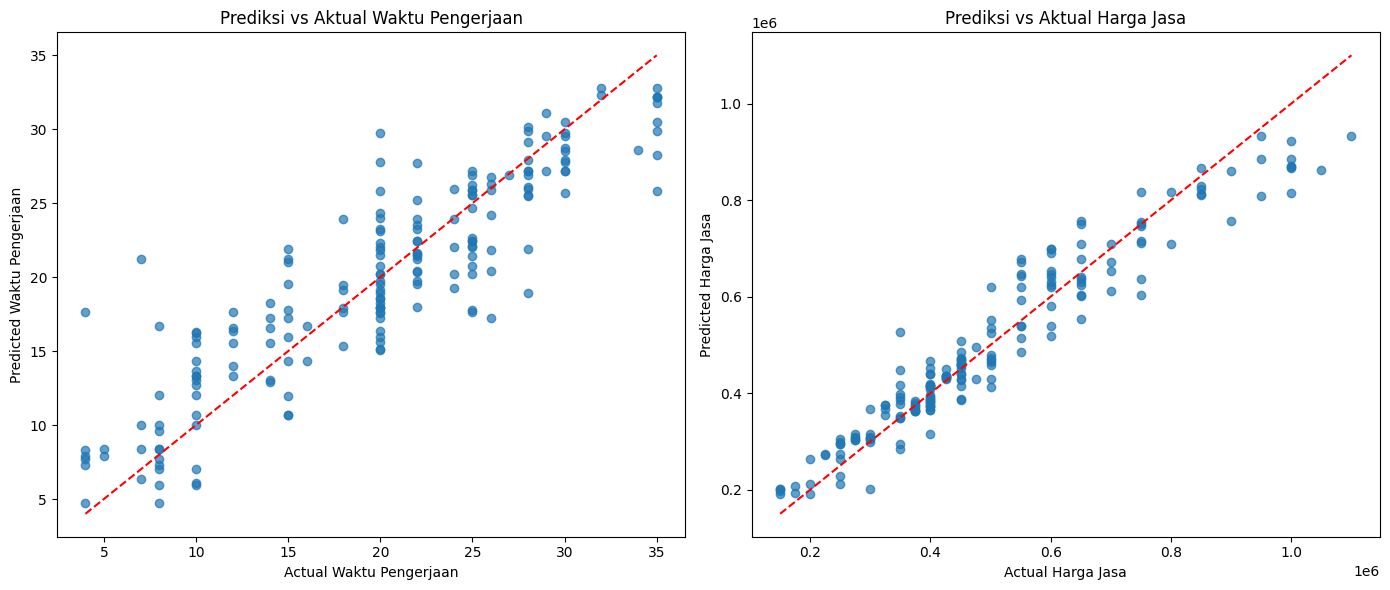

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: waktu_pengerjaan
axes[0].scatter(y_test_1, y_pred_1, alpha=0.7)
axes[0].set_xlabel('Actual Waktu Pengerjaan')
axes[0].set_ylabel('Predicted Waktu Pengerjaan')
axes[0].set_title('Prediksi vs Aktual Waktu Pengerjaan')
axes[0].plot([y_test_1.min(), y_test_1.max()], [y_test_1.min(), y_test_1.max()], 'r--')

# Plot 2: harga_jasa
axes[1].scatter(y_test_2, y_pred_2, alpha=0.7)
axes[1].set_xlabel('Actual Harga Jasa')
axes[1].set_ylabel('Predicted Harga Jasa')
axes[1].set_title('Prediksi vs Aktual Harga Jasa')
axes[1].plot([y_test_2.min(), y_test_2.max()], [y_test_2.min(), y_test_2.max()], 'r--')

plt.tight_layout()
plt.show()

### Save Model

In [112]:
joblib.dump(pipe_lr, '../models/model_akhir.pkl')

['../models/model_akhir.pkl']